In [3]:
!pip install imblearn

     |████████████████████████████████| 189 kB 1.4 MB/s            
You should consider upgrading via the '/home/vb/.pyenv/versions/3.9.7/envs/artefact/bin/python3.9 -m pip install --upgrade pip' command.


In [4]:
# Import relevant libraries and packages
import pickle
import pandas as pd
import numpy as np
import seaborn as sns

import datetime

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import re
import emoji #install pip install emoji --upgrade

import spacy #python -m spacy download en_core_web_md
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

import enchant
from enchant.checker import SpellChecker

[nltk_data] Downloading package punkt to /home/vb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Phase 0 => Data setup

Creation of new dataset to run classification model with only 2 dimensions : 'review content' and 'rating'.

In [5]:
path = "data/reviews_tgtg_v2.pkl"

with open(path, 'rb') as f:
    df = pickle.load(f)

df.head(5)

,review_content,rating,date,source,preprocessed_review
0,It does exactly what it says it does efficient...,5,2021-12,Google,"[exactli, say, effici, save, food, fill, belli..."
1,"Well, I've only done 2 different vendors. The ...",4,2021-12,Google,"[well, done, differ, vendor, first, donut, sho..."
2,Still in my first week. And I'm looking forwar...,5,2021-12,Google,"[still, first, week, look, forward, great, dea..."
3,loving the app.,5,2021-12,Google,"[love, app]"
4,AT FIRST: 1) Lovely experience. charming staff...,2,2021-12,Google,"[first, love, experi, charm, staff, moder, hi,..."


In [6]:
df_test1 = df[['review_content','rating']]

### A) Label creation

Since the dataset is inbalanced, 2 scenarii need to be designed depending on the success of ML prediction :
- 1 scenario with 5 categories corresponding to the 5 different scores (from 1 to 5)
- 1 scenario with 3 macro-categories gathering scores 

##### Scenario 1 => 5 categories

In [7]:
# function creating labels accroding to rating
def label_rating (row):
    if row['rating'] == 1 :
        return '1 - awful'
    if row['rating'] == 2 :
        return '2 - bad'
    if row['rating'] == 3 :
        return '3 - neutral'
    if row['rating'] == 4 :
        return '4 - good'
    if row['rating'] == 5 :
        return '5 - awesome'
    return 'Other'

In [8]:
# application of function to create labels
df_test1['rating_label'] = df_test1.apply (lambda row: label_rating(row), axis=1)
df_test1.head()

/tmp/ipykernel_8897/3099612617.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test1['rating_label'] = df_test1.apply (lambda row: label_rating(row), axis=1)


,review_content,rating,rating_label
0,It does exactly what it says it does efficient...,5,5 - awesome
1,"Well, I've only done 2 different vendors. The ...",4,4 - good
2,Still in my first week. And I'm looking forwar...,5,5 - awesome
3,loving the app.,5,5 - awesome
4,AT FIRST: 1) Lovely experience. charming staff...,2,2 - bad


In [9]:
# creation of dictionary scenario 1
rating1_df = df_test1[['rating_label', 'rating']].drop_duplicates().sort_values('rating')
ratinglabel1_to_id = dict(rating1_df.values)
id_to_ratinglabel1 = dict(rating1_df[['rating', 'rating_label']].values)

In [10]:
ratinglabel1_to_id 

{'1 - awful': 1,
 '2 - bad': 2,
 '3 - neutral': 3,
 '4 - good': 4,
 '5 - awesome': 5}

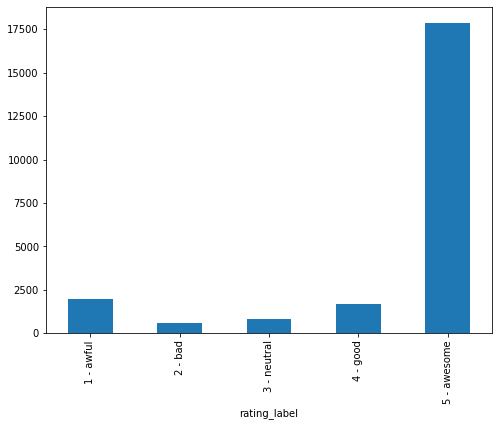

In [11]:
# distribution chart
fig = plt.figure(figsize=(8,6))
df_test1.groupby('rating_label').review_content.count().plot.bar(ylim=0)
plt.show()

##### Scenario 2 => 3 categories

- Bad = categories 1 & 2
- Neutral = category 3
- Good = categories 4 & 5

In [10]:
df_test2 = df[['review_content','rating']]

def label_rating2 (row):
    if row['rating'] == 1 :
        return '1 - bad'
    if row['rating'] == 2 :
        return '1 - bad'
    if row['rating'] == 3 :
        return '2 - neutral'
    if row['rating'] == 4 :
        return '3 - good'
    if row['rating'] == 5 :
        return '3 - good'
    return 'Other'

df_test2['rating_label'] = df_test2.apply (lambda row: label_rating2(row), axis=1)
df_test2.head()

/tmp/ipykernel_12154/1835289214.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test2['rating_label'] = df_test2.apply (lambda row: label_rating2(row), axis=1)


,review_content,rating,rating_label
0,It does exactly what it says it does efficient...,5,3 - good
1,"Well, I've only done 2 different vendors. The ...",4,3 - good
2,Still in my first week. And I'm looking forwar...,5,3 - good
3,loving the app.,5,3 - good
4,AT FIRST: 1) Lovely experience. charming staff...,2,1 - bad


In [11]:
# creation of dictionary scenario 2
rating2_df = df_test2[['rating_label', 'rating']].drop_duplicates().sort_values('rating')
ratinglabel2_to_id = dict(rating2_df.values)
id_to_ratinglabel2 = dict(rating2_df[['rating', 'rating_label']].values)

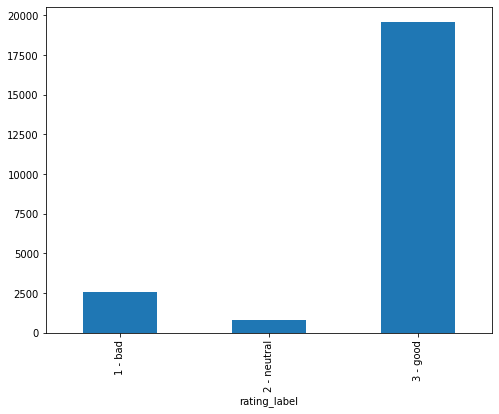

In [12]:
# distribution chart
fig = plt.figure(figsize=(8,6))
df_test2.groupby('rating_label').review_content.count().plot.bar(ylim=0)
plt.show()

# Phase 1 => Preparatory work

### A) Feature engineering

#### Step 1 => Features created directly from text

1. Number of Characters

In [13]:
df_test1.head()

,review_content,rating,rating_label
0,It does exactly what it says it does efficient...,5,5 - awesome
1,"Well, I've only done 2 different vendors. The ...",4,4 - good
2,Still in my first week. And I'm looking forwar...,5,5 - awesome
3,loving the app.,5,5 - awesome
4,AT FIRST: 1) Lovely experience. charming staff...,2,2 - bad


In [12]:
def count_chars(text):
    return len(text)

2. Number of words

In [14]:
def count_words(text):
    return len(text.split())

3. Number of capital characters

In [15]:
def count_capital_chars(text):
    count=0
    for i in text:
        if i.isupper()== True: #isupper() method returns: True if characters in a string are uppercase characters
            count+=1
    return count

4. Number of capital words

In [16]:
def count_capital_words(text):
    return sum(map(str.isupper, text.split()))

5. Count the number of punctuations

In [17]:
def count_punctuations(text):
    punctuations="!#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
    d=dict()
    for i in punctuations:
        d[str(i)+'count']=text.count(i)
    return d 

6. Number of words in quotes

In [18]:
def count_words_in_quotes(text):
    x = re.findall("'.'|'.'", text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count

7. Number of sentences

In [19]:
def count_sent(text):
    return len(nltk.sent_tokenize(text))

8. Count the number of unique words

In [20]:
def count_unique_words(text):
    return len(set(text.split()))

9. Count of hashtags

In [21]:
def count_htags(text):
    x = re.findall(r'(#w[A-Za-z0-9]*)', text)
    return len(x) 

10. Count of mentions

In [22]:
def count_mentions(text):
    x = re.findall(r'(@w[A-Za-z0-9]*)', text)
    return len(x)

11. Count of stopwords

In [25]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 45.7 MB 740 kB/s            
You should consider upgrading via the '/home/vb/.pyenv/versions/artefact/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [26]:
nlp = spacy.load("en_core_web_md") # need to use the medium model (not small one = en_core_web_md)
nlp.Defaults.stop_words -= {"no", "not", "isn't","can't", "cannot", "doesn't", "don't", "but", "won't", "shouldn't"} #to remove words form Spacy stopwords

stopwords = nlp.Defaults.stop_words

print(len(stopwords))

322


In [27]:
print(stopwords)

{'whence', 'me', 'as', 'before', 'own', 'however', 'thereafter', 'nor', 'various', 'others', 'have', 'nobody', 'front', 'during', 'except', 'am', 'done', 'yet', 'its', 'see', 'thereupon', 'much', 'quite', 'give', 'it', 'had', "'s", 'several', 'were', 'often', 'otherwise', "n't", 'upon', 'also', 'whither', 'wherever', 'from', 'my', 'we', '‘ve', '’s', 'for', 'towards', 'n’t', 'our', 'namely', 'around', 'above', 'whereupon', 'further', 'may', 'him', 'she', 'itself', "'m", 'first', 'under', 'alone', 'bottom', 'anywhere', 'against', 'now', 'been', 'still', 'n‘t', 'after', 'up', 'serious', 'former', '’ve', 'enough', 'thence', 'are', 'everything', 'seem', 'might', 'did', 'out', 'some', 'if', 'side', 'all', 'rather', 'here', 'than', 'can', "'ve", 'both', 'anyhow', 'using', 'anything', 'could', 'hereupon', 'sixty', 'an', 'beside', 'perhaps', 'became', 'anyway', 'should', 'therein', 'four', 'show', 'so', 'he', 'how', 'six', 'more', 'thus', 'never', 'within', 'next', 'nothing', 'you', 'there', 'm

In [28]:
def count_stopwords(text):
    stop_words = stopwords  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

11. Count of emojis

In [29]:
def count_emoji(text):
    return emoji.emoji_count(text)

##### Application of 1st round of feature engineering

In [30]:
#apply all the functions just created above, to the whole dataset
df_test1['char_count'] = df_test1["review_content"].apply(lambda x:count_chars(x))
df_test1['word_count'] = df_test1["review_content"].apply(lambda x:count_words(x))
df_test1['sent_count'] = df_test1["review_content"].apply(lambda x:count_sent(x))
df_test1['capital_char_count'] = df_test1["review_content"].apply(lambda x:count_capital_chars(x))
df_test1['capital_word_count'] = df_test1["review_content"].apply(lambda x:count_capital_words(x))
df_test1['quoted_word_count'] = df_test1["review_content"].apply(lambda x:count_words_in_quotes(x))
df_test1['stopword_count'] = df_test1["review_content"].apply(lambda x:count_stopwords(x))
df_test1['unique_word_count'] = df_test1["review_content"].apply(lambda x:count_unique_words(x))
df_test1['htag_count'] = df_test1["review_content"].apply(lambda x:count_htags(x))
df_test1['mention_count'] = df_test1["review_content"].apply(lambda x:count_mentions(x))
df_test1['punct_count'] = df_test1["review_content"].apply(lambda x:count_punctuations(x))
df_test1['emoji_count'] = df_test1["review_content"].apply(lambda x:count_emoji(x))

/tmp/ipykernel_8897/3117292899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test1['char_count'] = df_test1["review_content"].apply(lambda x:count_chars(x))


In [31]:
df_test1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22968 entries, 0 to 1467
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   review_content      22968 non-null  object
 1   rating              22968 non-null  int64 
 2   rating_label        22968 non-null  object
 3   char_count          22968 non-null  int64 
 4   word_count          22968 non-null  int64 
 5   sent_count          22968 non-null  int64 
 6   capital_char_count  22968 non-null  int64 
 7   capital_word_count  22968 non-null  int64 
 8   quoted_word_count   22968 non-null  int64 
 9   stopword_count      22968 non-null  int64 
 10  unique_word_count   22968 non-null  int64 
 11  htag_count          22968 non-null  int64 
 12  mention_count       22968 non-null  int64 
 13  punct_count         22968 non-null  object
 14  emoji_count         22968 non-null  int64 
dtypes: int64(12), object(3)
memory usage: 2.8+ MB


#### Step 2 => New features created directly from features above and applied on df

12. Calculating average word length

In [32]:
df_test1['avg_wordlength'] = df_test1['char_count']/df_test1['word_count']

13. Calculating average sentence length

In [33]:
df_test1['avg_sentlength'] = df_test1['word_count']/df_test1['sent_count']

14. Ratio unique words vs word count

In [34]:
df_test1['unique_vs_words'] = df_test1['unique_word_count']/df_test1['word_count']

15. Ratio stopwords count vs words count

In [35]:
df_test1['stopwords_vs_words'] = df_test1['stopword_count']/df_test1['word_count']

In [36]:
df_test1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22968 entries, 0 to 1467
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   review_content      22968 non-null  object 
 1   rating              22968 non-null  int64  
 2   rating_label        22968 non-null  object 
 3   char_count          22968 non-null  int64  
 4   word_count          22968 non-null  int64  
 5   sent_count          22968 non-null  int64  
 6   capital_char_count  22968 non-null  int64  
 7   capital_word_count  22968 non-null  int64  
 8   quoted_word_count   22968 non-null  int64  
 9   stopword_count      22968 non-null  int64  
 10  unique_word_count   22968 non-null  int64  
 11  htag_count          22968 non-null  int64  
 12  mention_count       22968 non-null  int64  
 13  punct_count         22968 non-null  object 
 14  emoji_count         22968 non-null  int64  
 15  avg_wordlength      22968 non-null  float64
 16  avg_s

16. Adding columns based on punctuation used in each text

In [37]:
# Creating new dataframe retrieving all the different punctuation used in each text
df_punct = pd.DataFrame(list(df_test1.punct_count))

# Merging punctuation DataFrame with main DataFrame
df_test1 = pd.merge(df_test1, df_punct, left_index=True, right_index=True)

# Dropping "punct_count" column from main DataFrame
df_test1.drop(columns=['punct_count'],inplace=True)
df_test1.columns

Index(['review_content', 'rating', 'rating_label', 'char_count', 'word_count',
       'sent_count', 'capital_char_count', 'capital_word_count',
       'quoted_word_count', 'stopword_count', 'unique_word_count',
       'htag_count', 'mention_count', 'emoji_count', 'avg_wordlength',
       'avg_sentlength', 'unique_vs_words', 'stopwords_vs_words', '!count',
       '#count', '$count', '%count', '&count', ''count', '(count', ')count',
       '*count', '+count', ',count', '-count', '.count', '/count', ':count',
       ';count', '<count', '=count', '>count', '?count', '@count', '[count',
       '\count', ']count', '^count', '_count', '`count', '{count', '|count',
       '}count', '~count'],
      dtype='object')

In [38]:
df_test1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22968 entries, 0 to 19847
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   review_content      22968 non-null  object 
 1   rating              22968 non-null  int64  
 2   rating_label        22968 non-null  object 
 3   char_count          22968 non-null  int64  
 4   word_count          22968 non-null  int64  
 5   sent_count          22968 non-null  int64  
 6   capital_char_count  22968 non-null  int64  
 7   capital_word_count  22968 non-null  int64  
 8   quoted_word_count   22968 non-null  int64  
 9   stopword_count      22968 non-null  int64  
 10  unique_word_count   22968 non-null  int64  
 11  htag_count          22968 non-null  int64  
 12  mention_count       22968 non-null  int64  
 13  emoji_count         22968 non-null  int64  
 14  avg_wordlength      22968 non-null  float64
 15  avg_sentlength      22968 non-null  float64
 16  uniq

In [39]:
df_test1.describe()

,rating,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,htag_count,...,[count,\count,]count,^count,_count,`count,{count,|count,}count,~count
count,22968.000000,22968.000000,22968.000000,22968.000000,22968.000000,22968.000000,22968.000000,22968.000000,22968.000000,22968.000000,...,22968.000000,22968.000000,22968.000000,22968.000000,22968.000000,22968.000000,22968.0,22968.0,22968.0,22968.000000
mean,4.433473,121.877699,22.753701,2.080329,2.943530,0.565482,0.000087,10.032132,19.483063,0.000044,...,0.000218,0.000044,0.000218,0.000610,0.000305,0.000087,0.0,0.0,0.0,0.000610
std,1.226021,157.477405,29.794663,1.711031,4.837543,1.488223,0.009331,15.248243,21.407197,0.006598,...,0.017457,0.006598,0.017457,0.034911,0.021883,0.009331,0.0,0.0,0.0,0.026387
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
25%,5.000000,31.000000,6.000000,1.000000,1.000000,0.000000,0.000000,1.000000,6.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
50%,5.000000,69.000000,13.000000,1.000000,2.000000,0.000000,0.000000,5.000000,12.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
75%,5.000000,151.000000,28.000000,3.000000,3.000000,1.000000,0.000000,13.000000,26.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
max,5.000000,4894.000000,871.000000,37.000000,166.000000,47.000000,1.000000,438.000000,448.000000,1.000000,...,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,0.0,0.0,0.0,2.000000


In [40]:
df_test1.head()

,review_content,rating,rating_label,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,...,[count,\count,]count,^count,_count,`count,{count,|count,}count,~count
0,It does exactly what it says it does efficient...,5,5 - awesome,97,17,2,2,0,0,8,...,0,0,0,0,0,0,0,0,0,0
0,Not that great to go more like I have had this...,5,5 - awesome,1267,271,2,14,9,0,133,...,0,0,0,0,0,0,0,0,0,0
0,TOBY CARVERY LATE CANCELLATION 30 minutes befo...,1,1 - awful,299,51,3,34,4,0,18,...,0,0,0,0,0,0,0,0,0,0
1,"Well, I've only done 2 different vendors. The ...",4,4 - good,267,50,6,9,2,0,18,...,0,0,0,0,0,0,0,0,0,0
1,Barley Farm - Eccles This was the first time u...,5,5 - awesome,1021,206,15,33,14,0,98,...,0,0,0,0,0,0,0,0,0,0


### B) Preprocessing methodology

In [41]:
# transform emojis into words
def emo_trans(text):
    text=emoji.demojize(text)
    text=text.replace(":"," ")
    text=' '.join(text.split())
    return text

In [42]:
# remove repeated characters
class Solution:
    def solve(self, s):
        seen = s[0]
        ans = s[0]
        for i in s[1:]:
            if i != seen:
                ans += i
                seen = i
        return ans

In [43]:
ob = Solution()

In [44]:
# to correct mispelling
def correcter_words(text):
    text=text
    chkr = SpellChecker("en_US",text)
    for err in chkr:
        err.suggest()
        sug = err.suggest()[0]
        err.replace(sug)
    text = chkr.get_text()
    return text

In [50]:
# function to run preprocessing
def preprocessing(text):
    text=text.lower() # to put in lower case
    text=' '.join(text.split()) # to remove extra white spaces (whichever how many)
    text=re.sub("'", "", text) # to avoid removing contractions in english
    text=emo_trans(text) # to transform emojis into words
    text=re.sub("@[A-Za-z0-9_]+","", text) # to remove mentions
    text=re.sub("#[A-Za-z0-9_]+","", text) # to remove hashtags
    text=re.sub(r"http\S+", "", text) # to remove urls
    text=re.sub(r"www.\S+", "", text) # to remove urls
    text=re.sub('((www.[^s]+)|(https?://[^s]+))',' ',text) # to remove urls - 3rd version
    text=re.sub("[^a-z0-9]"," ", text) # to remove non-alphanumerical characters
    #text = ob.solve(text)
    #text = correcter_words(text)
    tokens = word_tokenize(text) # to tokenize
    tokens_no_punctuation = [t for t in tokens if t.isalpha()]
    tokens_no_stop = [t for t in tokens_no_punctuation if t not in stopwords]
    lemmatizer = WordNetLemmatizer()
    token_lem = [lemmatizer.lemmatize(t) for t in tokens_no_stop]
    return token_lem

In [51]:
df_test1['preprocessed_content'] = df_test1['review_content'].apply(lambda x:preprocessing(x))

### D) Splitting data (df_train & df_test) & Definition of corresponding ys

In [101]:
df_test1 = df_test1.sample(len(df_test1))
df_train = df_test1[:int(0.8*len(df_test1))]
df_test = df_test1[int(0.8*len(df_test1)):]

In [ ]:
y_train = df_train['rating']

In [100]:
df_train = df_train.drop(columns=['rating_label','rating'])

In [ ]:
y_test = df_test['rating']

In [ ]:
df_test = df_test.drop(columns=['rating_label','rating'])

### E) TF-IDF

So that the ML model won't be skewed with test data taken into account in its designing, TF-IDF will be done on df_train only.

In few words, reminder of what TF_IDF is:
Extracting features from text is to use the bag of words model: a model where for each document, a complaint narrative in our case, the presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored.
Specifically, for each term in our dataset, we will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. We will use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of consumer complaint narratives.

Due to dataset size, the number of words will be set up with 3000 maximum in the 'max_features' hyperparameter.

In [57]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', max_features=3000, encoding='latin-1', ngram_range=(1, 3), stop_words='english')

features_train = tfidf.fit_transform(df_train['review_content']).toarray()
labels_train = df_train['rating']

In [58]:
features_train.shape

(18374, 3000)

On df_test, TF_IDF is created with .transform only.

In [59]:
features_test = tfidf.transform(df_test['review_content']).toarray()

In [61]:
features_test.shape

(4594, 3000)

### F)  Definition of X

#### df_train

In [64]:
X_train = features_train
X_train.shape

(18374, 3000)

In [62]:
#y_train = df_train['rating']

#### df_test

In [66]:
X_test = features_test
X_test.shape

(4594, 3000)

In [63]:
#y_test = df_test['rating']

### G) Reshaping Train dataset

Since dataset is imbalanced with an over-representation of 5* reviews, has been decided to reduce the share of these to reviews

In [69]:
# checking of nb of 5* reviews
len(np.where(y_train==5)[0])

14336

In [71]:
# creation of a 'to_delete' variable storing the 10000 samples of 5* reviews
to_delete = np.random.choice(np.where(y_train==5)[0],10000)

In [73]:
# creation of a 'to_keep' variable storing the reviews to be kept
to_keep = set(range(len(X_train))) - set(to_delete)

In [77]:
# storing the reshaped data in X_train_bis based on the 'to_keep' variable containing the sample to be kept
X_train_bis = X_train[list(to_keep),:]

In [84]:
# storing the corresponding y of reshaped data in y_train_bis, based on the 'to_keep' variable containing the sample to be kept
y_train_bis = np.array(y_train)[list(to_keep)]

In [86]:
# checking of the size of X_train_bis & y_train_bis
X_train_bis.shape, y_train_bis.shape

(11163,)

Now, each of 22968 consumer reviews narratives is represented by 8728 features, representing the tf-idf score for different unigrams and bigrams.

### F) Concatenation (to be done before TF-IDF)

In [72]:
df_prep = pd.concat([df_1star,df_2star,df_3star,df_4star,df_5star], axis=0)

In [73]:
features_prep = tfidf.fit_transform(df_prep['review_content']).toarray()
labels_prep = df_prep['rating']

### G) N-grams (optional)

We can use sklearn.feature_selection.chi2 to find the terms that are the most correlated with each of the rating_label:

In [80]:
N = 5 #top x associated words to be displayed
#for rating_label, rating in sorted(ratinglabel1_to_id.items()):
features_chi2_2star = chi2(features_2star, labels_2star) # == rating
indices = np.argsort(features_chi2_2star[0])
feature_names = np.array(tfidf.get_feature_names_out())[indices]
unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
quadrigrams = [v for v in feature_names if len(v.split(' ')) == 4]
print("# '{}' star :".format(labels_2star))
print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))
print("  . Most correlated quadrigrams:\n. {}".format('\n. '.join(quadrigrams[-N:])))

# '3        2
4        2
4        2
7        2
14       2
        ..
19804    2
19808    2
19816    2
19830    2
19840    2
Name: rating, Length: 597, dtype: int64' star :
  . Most correlated unigrams:
. addicted
. addictive
. adding
. addition
. additional
  . Most correlated bigrams:
. add option
. added app
. added bonus
. actually available
. app lovely
  . Most correlated trigrams:
. absolutely fantastic app
. absolutely fantastic idea
. absolutely great app
. absolutely love app
. absolutely love idea
  . Most correlated quadrigrams:
. amazing app easy use
. amazing app great food
. amazing app great idea
. amazing app amazing idea
. app love saving food


In [75]:
N = 5 #top x associated words to be displayed
for rating_label, rating in sorted(ratinglabel1_to_id.items()):
    features_chi2_prep = chi2(features_prep, labels_prep == rating)
    indices = np.argsort(features_chi2_prep[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    print("# '{}' star :".format(rating))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

# '1' star :
  . Most correlated unigrams:
. scam
. cancelled
. sold
. useless
. rubbish
  . Most correlated bigrams:
. complete waste
. don bother
. time money
. doesn work
. waste time
  . Most correlated trigrams:
. app doesn work
. total waste time
. don waste time
. complete waste time
. waste time money
# '2' star :
  . Most correlated unigrams:
. poor
. update
. notifications
. explanation
. sucks
  . Most correlated bigrams:
. didn work
. make sense
. near live
. needs lot
. nice idea
  . Most correlated trigrams:
. time open app
. nice app great
. app does allow
. twice order cancelled
. poor customer service
# '3' star :
  . Most correlated unigrams:
. translate
. available
. ok
. option
. okay
  . Most correlated bigrams:
. closest place
. new york
. vegetarian options
. idea area
. mixed experience
  . Most correlated trigrams:
. looks like great
. idea needs work
. app just doesn
. managed magic bag
. great idea unfortunately
# '4' star :
  . Most correlated unigrams:
. st

# Phase 2 => Topic Classification

### Step 1 - Dataset augmentation

In [86]:
# example of combining random oversampling and undersampling for imbalanced data
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
# define dataset
X = df_prep.drop(columns=["rating","rating_label"])
y = df_prep["rating_label"]
# summarize initial class distribution
print(Counter(y))
# define oversampling strategy
sampling_strategy = {'1 - awful': 3445, '2 - bad': 3445, '3 - neutral': 3445, '4 - good':3445}
over = RandomOverSampler(sampling_strategy=sampling_strategy)
# fit and apply the transform
X, y = over.fit_resample(X, y)
# summarize re-worked class distribution
print(Counter(y))
# define undersampling strategy
sampling_strategy = {'5 - awesome':9188}
under = RandomUnderSampler(sampling_strategy=sampling_strategy)
# fit and apply the transform
X, y = under.fit_resample(X, y)
# summarize final class distribution
print(Counter(y))

Counter({'5 - awesome': 17887, '1 - awful': 1971, '4 - good': 1689, '3 - neutral': 824, '2 - bad': 597})
Counter({'5 - awesome': 17887, '1 - awful': 3445, '2 - bad': 3445, '3 - neutral': 3445, '4 - good': 3445})
Counter({'5 - awesome': 9188, '1 - awful': 3445, '2 - bad': 3445, '3 - neutral': 3445, '4 - good': 3445})


### Step 2 - Dataset splitting between train/test/validation

In [88]:
# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y, test_size=0.2, shuffle = True, 
                                                    random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify= y_train, test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2


print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

X_train shape: (13780, 48)
X_test shape: (4594, 48)
y_train shape: (13780,)
y_test shape: (4594,)
X_val shape: (4594, 48)
y_val shape: (4594,)


In [89]:
y_train.value_counts()/y_train.shape[0]*100

5 - awesome    40.0
4 - good       15.0
2 - bad        15.0
3 - neutral    15.0
1 - awful      15.0
Name: rating_label, dtype: float64

In [90]:
y_test.value_counts()/y_test.shape[0]*100

5 - awesome    40.008707
1 - awful      14.997823
4 - good       14.997823
2 - bad        14.997823
3 - neutral    14.997823
Name: rating_label, dtype: float64

In [91]:
y_val.value_counts()/y_val.shape[0]*100

5 - awesome    40.008707
2 - bad        14.997823
1 - awful      14.997823
3 - neutral    14.997823
4 - good       14.997823
Name: rating_label, dtype: float64

### Step 3 - ML Classifications applied

We are now ready to experiment with different machine learning models, evaluate their accuracy and find the source of any potential issues.

We will benchmark the following 5 models:

- Logistic Regression
- (Multinomial) Naive Bayes
- Linear Support Vector Machine
- Random Forest
- K-Nearest Neighbor (KNN)

/home/vb/.pyenv/versions/3.9.7/envs/artefact/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vb/.pyenv/versions/3.9.7/envs/artefact/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

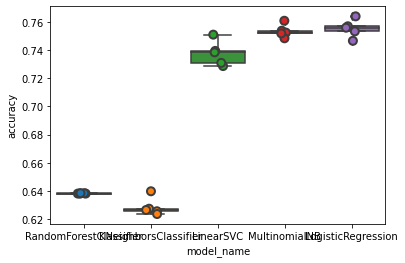

In [89]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    KNeighborsClassifier(n_neighbors = 5),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5 #nb of model
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_bis, y_train_bis, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])



sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [90]:
cv_df.groupby('model_name').accuracy.mean()

model_name
KNeighborsClassifier      0.628595
LinearSVC                 0.737617
LogisticRegression        0.755264
MultinomialNB             0.753382
RandomForestClassifier    0.638269
Name: accuracy, dtype: float64

### Step 4 - Performance ML Classification models comparison

2 models seem to perform well : SVC & Logistic regression.
We are going to look deeper in their performance.

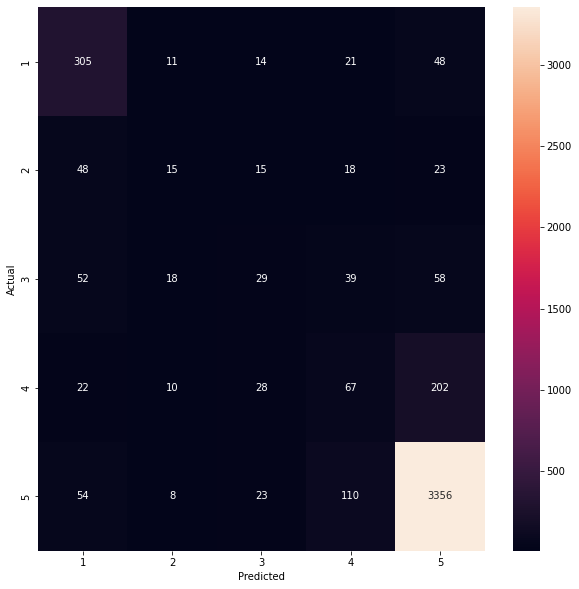

In [93]:
model = LinearSVC() 
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X_train_bis, y_train_bis, df_test1.index, test_size=0.2, random_state=0)
model.fit(X_train_bis, y_train_bis)
y_pred = model.predict(X_test)

#X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(features_prep, labels_prep, df_prep.index, test_size=0.2, random_state=0)
#model.fit(X_train, y_train)
#y_pred = model.predict(X_val)

#from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=rating1_df['rating'].values, yticklabels=rating1_df['rating'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [94]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.63      0.76      0.69       399
           2       0.24      0.13      0.17       119
           3       0.27      0.15      0.19       196
           4       0.26      0.20      0.23       329
           5       0.91      0.95      0.93      3551

    accuracy                           0.82      4594
   macro avg       0.46      0.44      0.44      4594
weighted avg       0.80      0.82      0.81      4594



/home/vb/.pyenv/versions/3.9.7/envs/artefact/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


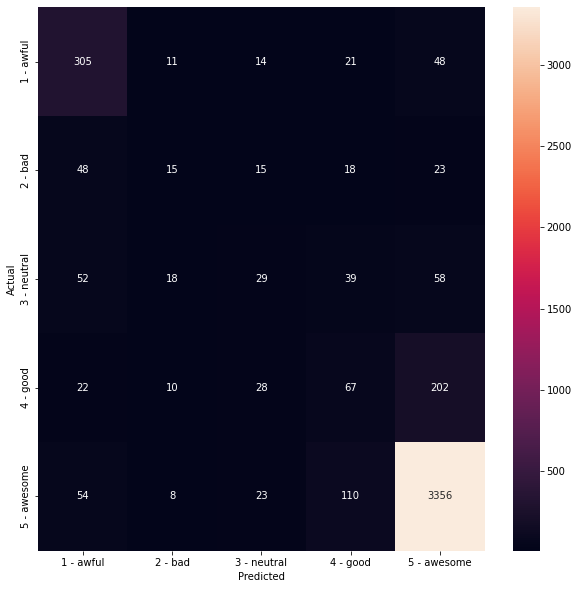

In [95]:
model2 = LogisticRegression()
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_test1.index, test_size=0.2, random_state=0)
model2.fit(X_train_bis, y_train_bis)
y_pred2 = model2.predict(X_test)
conf_mat2 = confusion_matrix(y_test, y_pred2)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=rating1_df['rating_label'].values, yticklabels=rating1_df['rating_label'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [96]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           1       0.62      0.76      0.68       399
           2       0.55      0.05      0.09       119
           3       0.33      0.08      0.12       196
           4       0.32      0.19      0.24       329
           5       0.89      0.97      0.93      3551

    accuracy                           0.83      4594
   macro avg       0.54      0.41      0.41      4594
weighted avg       0.80      0.83      0.80      4594



**Conclusion** => best ML is SVC. So this will be applied on Twitter reviews

# Phase 3 => ML Application on tweets

In [ ]:
path = "data/tweets2021tgtg.pkl"

with open(path, 'rb') as f:
    df_tweet = pickle.load(f)

df_tweet.head(5)

#### Application of 1st round of feature engineering

In [ ]:
df_tweet['char_count'] = df_tweet["review_content"].apply(lambda x:count_chars(x))
df_tweet['word_count'] = df_tweet["review_content"].apply(lambda x:count_words(x))
df_tweet['sent_count'] = df_tweet["review_content"].apply(lambda x:count_sent(x))
df_tweet['capital_char_count'] = df_tweet["review_content"].apply(lambda x:count_capital_chars(x))
df_tweet['capital_word_count'] = df_tweet["review_content"].apply(lambda x:count_capital_words(x))
df_tweet['quoted_word_count'] = df_tweet["review_content"].apply(lambda x:count_words_in_quotes(x))
df_tweet['stopword_count'] = df_tweet["review_content"].apply(lambda x:count_stopwords(x))
df_tweet['unique_word_count'] = df_tweet["review_content"].apply(lambda x:count_unique_words(x))
df_tweet['htag_count'] = df_tweet["review_content"].apply(lambda x:count_htags(x))
df_tweet['mention_count'] = df_tweet["review_content"].apply(lambda x:count_mentions(x))
df_tweet['punct_count'] = df_tweet["review_content"].apply(lambda x:count_punctuations(x))
df_tweet['emoji_count'] = df_tweet["review_content"].apply(lambda x:count_emoji(x))

#### Application of 2nd round of feature engineering

In [ ]:
df_tweet['avg_wordlength'] = df_tweet['char_count']/df_tweet['word_count']
df_tweet['avg_sentlength'] = df_tweet['word_count']/df_tweet['sent_count']
df_tweet['unique_vs_words'] = df_tweet['unique_word_count']/df_tweet['word_count']
df_tweet['stopwords_vs_words'] = df_tweet['stopword_count']/df_tweet['word_count']

In [ ]:
# Creating new dataframe retrieving all the different punctuation used in each text
df_punct_tweet = pd.DataFrame(list(df_tweet.punct_count))

# Merging punctuation DataFrame with main DataFrame
df_tweet = pd.merge(df_tweet, df_punct_tweet, left_index=True, right_index=True)

# Dropping "punct_count" column from main DataFrame
df_tweet.drop(columns=['punct_count'],inplace=True)
df_tweet.columns

#### Application of preprocessing

In [ ]:
df_tweet['preprocessed_content'] = df_tweet['review_content'].apply(lambda x:preprocessing(x))

#### ML application

#### Concatenation all datasets into one for topic modeling

In [ ]:
df_topic = pd.concat([df_prep,df_tweet], axis=0)